In [1]:
import pandas as pd
import os
import numpy as np
import itertools
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

In [2]:
df = pd.read_csv(os.getcwd() + '/data/data.csv').rename(columns={'Unnamed: 0':'sample_num'})

df.head()


,sample_num,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


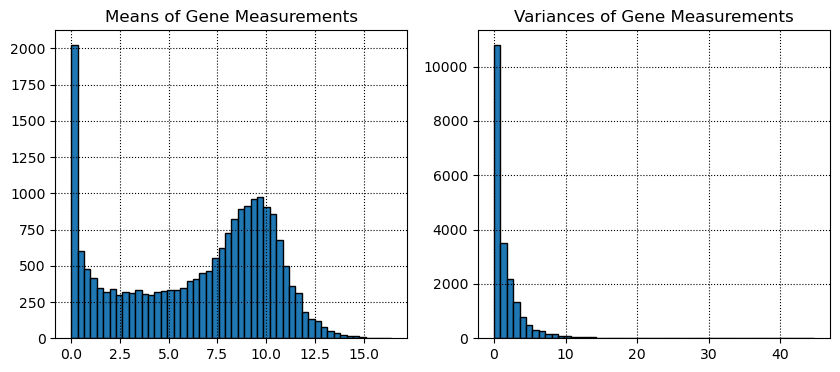

In [3]:
d = df.iloc[:, 1:].values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(np.mean(d, axis=0), bins=50, edgecolor='k')
ax[0].set_title('Means of Gene Measurements')
ax[1].hist(np.var(d, axis=0), bins=50, edgecolor='k')
ax[1].set_title('Variances of Gene Measurements')

plt.show()


/tmp/ipykernel_973502/19163146.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gene_var = df.var()


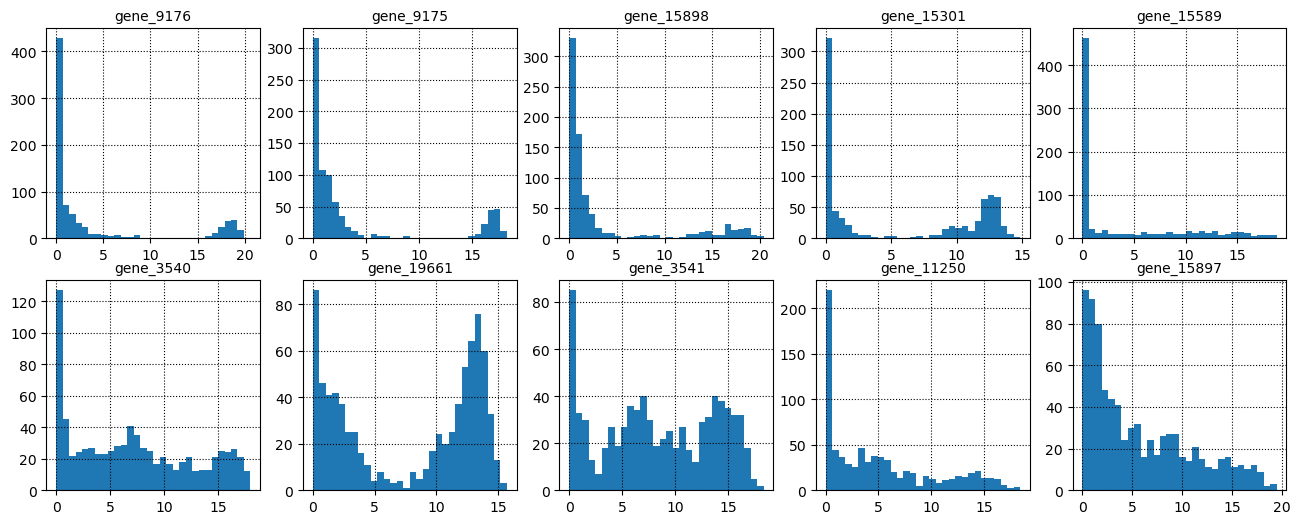

In [4]:

gene_var = df.var()
gene_var = gene_var.sort_values(ascending=False)
top_var_genes = np.array(gene_var.iloc[:10].index)#.reshape(2, 5)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
plots = zip(top_var_genes, axes.flatten())

for i, (gene, ax) in enumerate(plots):
    ax.hist(df[gene], bins=30)
    ax.set_title(f'{gene}', size=10)
plt.show()
    

In [5]:
def sctrmtrx(df, pairs, m, n, color_by=None):
    """
    Creates an m x n grid of scatter plots of selected columns. The number of column pairs must be equal to m x n.
    
    Parameters:
        df: Dataframe containing the columns to plot.
        pairs: Names of pairs of columns to plot.
        m: number of rows of scatter plots
        n: number of columns of scatter plots.
        color_by: pandas series, get from a column 

    Returns: 
        m x n Scatter plot figure.
    """
    

    fig, ax = plt.subplots(m, n, figsize=(16, 6))
    
    if color_by is not None:
        n_colors = len(color_by.unique())
        cm = plt.cm.get_cmap('turbo')
        colors = [cm(val/n_colors) for val in range(n_colors)]
        cmap = dict(zip(range(n_colors), colors))
        # cmap = {0:'tab:blue', 1:'tab:red', 2:'tab:orange', 3:'tab:green', 4:'tab:purple'}
        handles = [Line2D([], [], color=v, marker='o', linestyle='None', markersize=3, label=f'{k}', alpha=0.7, ) for k, v in cmap.items()]
        color = color_by.map(cmap)
        fig.legend(handles=handles,  loc='upper right', ncol=n_colors)
    else:
        color = 'tab:blue'

    d = dict(zip([(x, y) for x in range(0,m) for y in range(0,n)], pairs))
    for k, p in d.items():
        ax[k[0]][k[1]].scatter(df[p[0]], df[p[1]], c=color, s=25, alpha=0.7, edgecolor='k', linewidth=0.5)
        ax[k[0]][k[1]].set_xlabel(p[0])
        ax[k[0]][k[1]].set_ylabel(p[1])
 
    plt.suptitle('Scatter Plots', size=12)
    plt.tight_layout()
    plt.show()

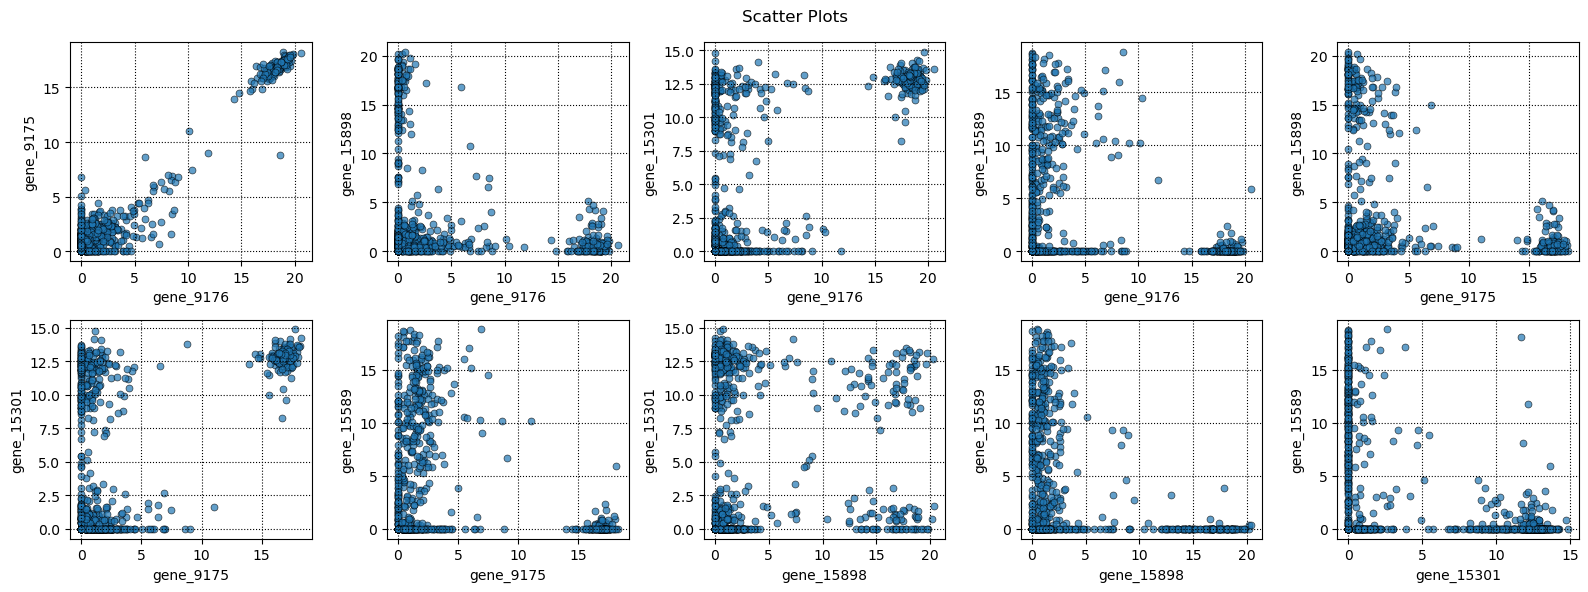

In [6]:
pairs = list(itertools.combinations(top_var_genes[:5], 2))
sctrmtrx(df=df, pairs=pairs, m=2, n=5)

In [7]:
def nboxplot(df, cols, title):
    """
    Boxplot of features.
    
    Parameters:
        df: Dataframe.
        cols: Columns within dataframe containing data to be plotted.

    Returns: 
        Boxplot figure.
    """
    plt.figure(figsize=(20, 3))

    boxplot = plt.boxplot(df[cols], 
                vert=True, 
                notch=True, 
                labels=cols,
                patch_artist=True,
                showfliers=False,
                  )

    cm = plt.cm.get_cmap('rainbow')
    colors = [cm(val/len(cols)) for val in range(len(cols))]
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.xticks(rotation=90)
    #plt.xlabel('Feature')
    plt.ylabel('Distribution')
    plt.title(title)
    plt.show()

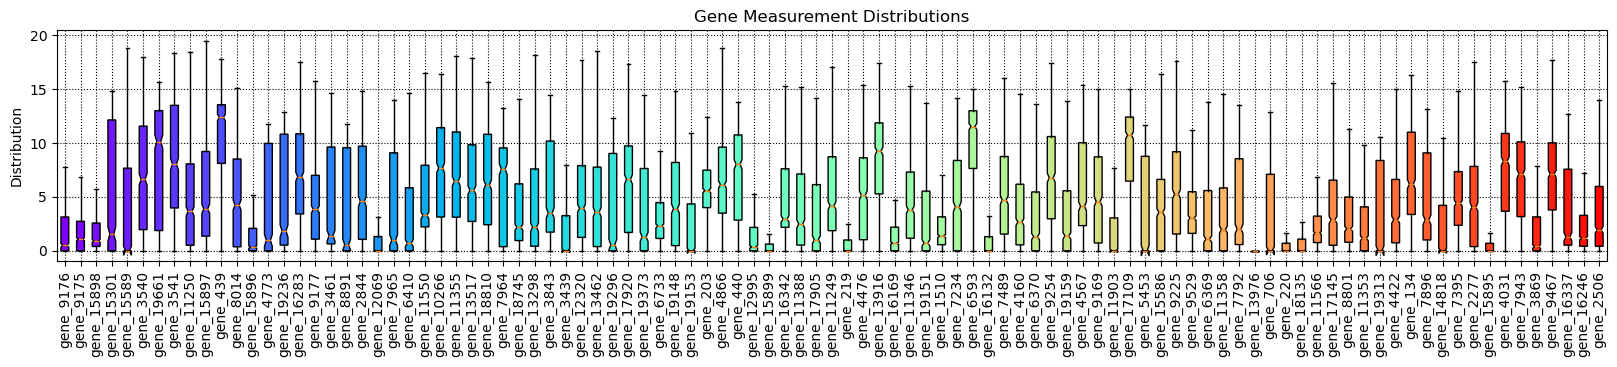

In [8]:
nboxplot(df=df, cols=list(gene_var.iloc[:99].index), title='Gene Measurement Distributions')

In [9]:
# drop genes with 0 variance
df = df.drop(columns=list(gene_var[gene_var == 0].index))

df.head()

,sample_num,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


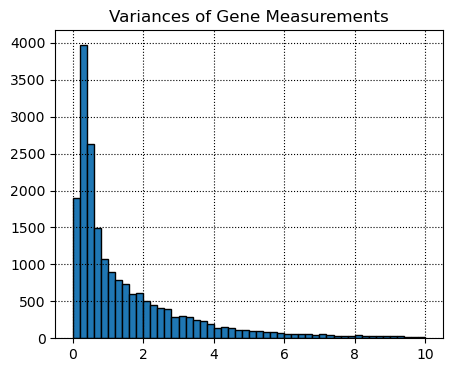

In [10]:
d = df.iloc[:, 1:].values
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(
        np.var(d, axis=0)[np.var(d, axis=0) <= 10], 
        bins=50, 
        edgecolor='k'
       )
#ax.set_xlim(0, 10)
ax.set_title('Variances of Gene Measurements')

plt.show()

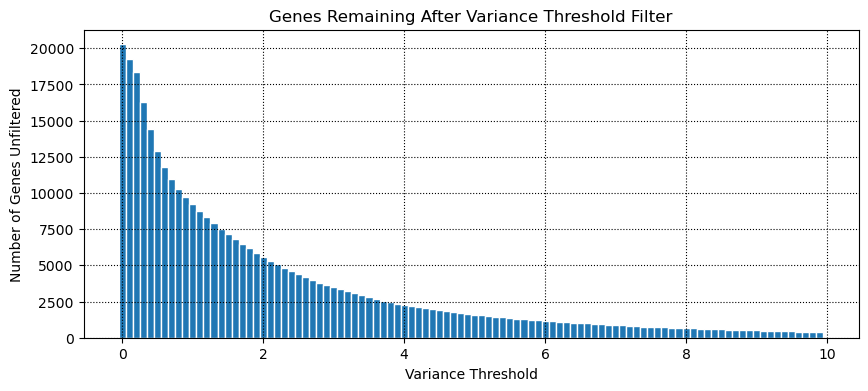

In [11]:
d = df.iloc[:, 1:].values

vts = {v:VarianceThreshold(v).fit(d) for v in np.arange(0, 10.0, 0.1)}
thresh_counts = pd.DataFrame.from_dict({round(k, 1):v.get_support().sum() for k, v in vts.items()}, orient='index')

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x=thresh_counts[0].index, height=thresh_counts[0], edgecolor='w', width=0.1)
ax.set_ylabel('Number of Genes Unfiltered')
ax.set_xlabel('Variance Threshold')
ax.set_title('Genes Remaining After Variance Threshold Filter')
plt.show()


In [12]:
# filter genes with less than variance threshold
var_filter = VarianceThreshold(3.0)
var_filter.fit(df.iloc[:, 1:].values)
df_var_filt = df.iloc[:, [True] + list(var_filter.get_support())].copy()


In [13]:

# scale
X = df_var_filt.iloc[:, 1:].values
ss = StandardScaler()
ss = ss.fit(X)
X_scaled = ss.transform(X)

pca = PCA()
X_scaled_pca = pca.fit_transform(X_scaled)
X_scaled_pca = pd.DataFrame(X_scaled_pca)
X_scaled_pca.columns = [f'PC_{n+1}' for n in X_scaled_pca.columns]

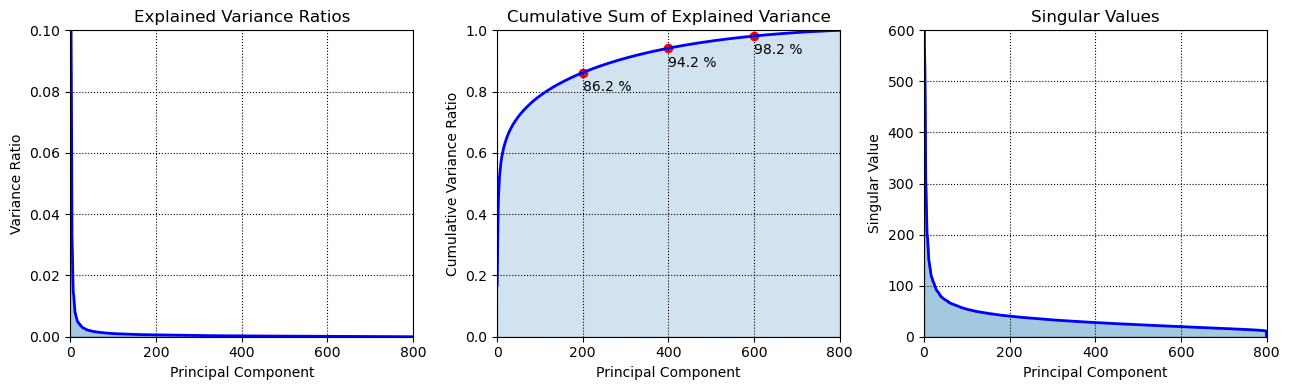

In [14]:
# plot variables
n = pca.n_components_
a = list(range(0, n))
r = range(pca.n_components_)

# PC variance ratios
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
ax[0].plot(r, pca.explained_variance_ratio_, linewidth=2, color='blue')
#ax[0].set_yscale('log')
ax[0].set_ylabel('Variance Ratio')
ax[0].set_xlabel('Principal Component')
ax[0].set_xlim(0, 801)
ax[0].set_ylim(0, 0.1)
ax[0].fill_between(a, pca.explained_variance_ratio_, color='tab:blue', alpha=0.4)
ax[0].set_title('Explained Variance Ratios', size=12)


# cumulative explained variance ratio
d = pd.DataFrame([200, 400, 600], 
              [
                  np.cumsum(pca.explained_variance_ratio_)[200],
                  np.cumsum(pca.explained_variance_ratio_)[400],
                  np.cumsum(pca.explained_variance_ratio_)[600],
              ]).reset_index().rename(columns={'index':'cum_var', 0:'pcs'})

ax[1].plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2, color='blue')
ax[1].scatter(d['pcs'], d['cum_var'], color='red')

for cum_var, x, y in zip(d['cum_var'], d['pcs'], d['cum_var']):
    ax[1].annotate(f'{round(cum_var * 100, 1) } %', xy=(x, y-0.06), )

ax[1].set_ylabel('Cumulative Variance Ratio')
ax[1].set_xlabel('Principal Component')
ax[1].set_xlim(0, 801)
ax[1].set_ylim(0, 1)
ax[1].fill_between(a, np.cumsum(pca.explained_variance_ratio_), color='tab:blue', alpha=0.2)
ax[1].set_title('Cumulative Sum of Explained Variance', size=12)


# singular values per PC
ax[2].plot(r, pca.singular_values_, linewidth=2, color='blue')
#ax[0].set_yscale('log')
ax[2].set_ylabel('Singular Value')
ax[2].set_xlabel('Principal Component')
ax[2].set_xlim(0, 801)
ax[2].set_ylim(0, 600)
ax[2].fill_between(a, pca.singular_values_, color='tab:blue', alpha=0.4)
ax[2].set_title('Singular Values', size=12)
plt.tight_layout()
plt.show()


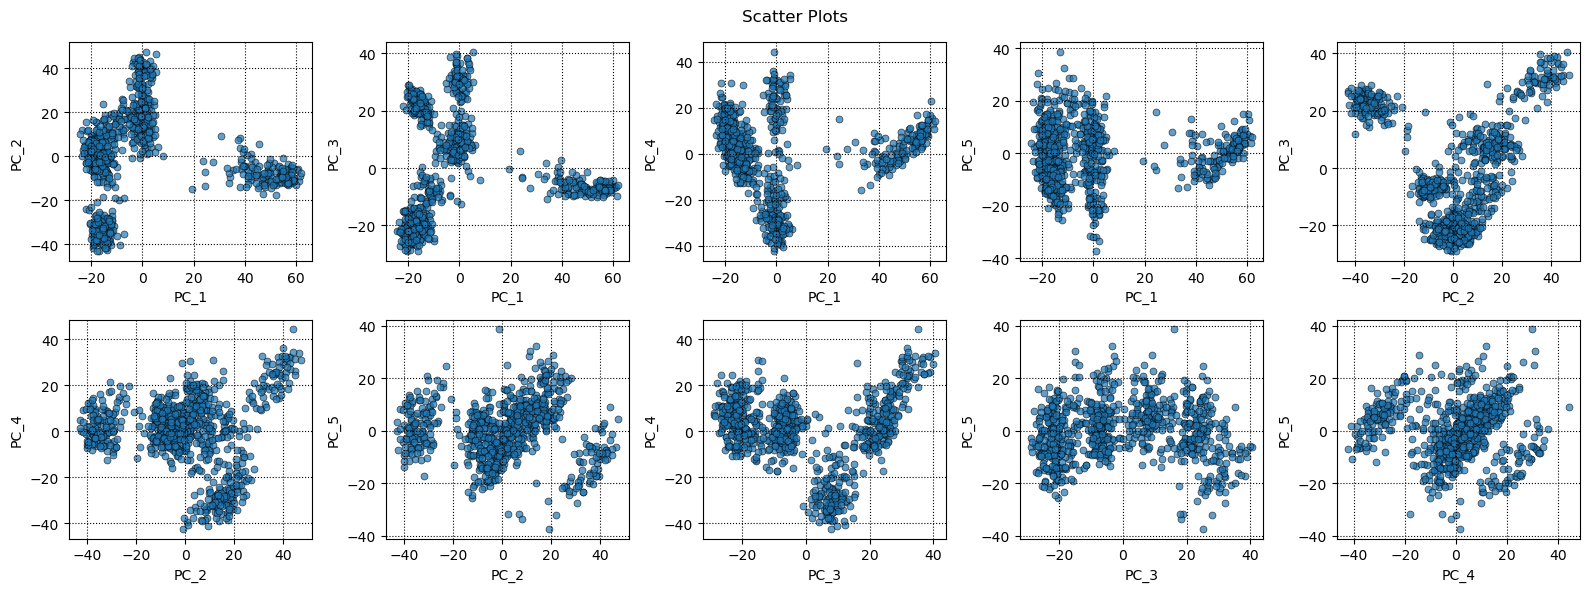

In [15]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=X_scaled_pca, pairs=pairs, m=2, n=5)

In [16]:
X_train = X_scaled_pca.iloc[:, :400]
X_train.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_391,PC_392,PC_393,PC_394,PC_395,PC_396,PC_397,PC_398,PC_399,PC_400
0,-18.332826,-32.457489,23.136919,-0.770089,-2.072549,-0.158964,20.808869,-0.993871,3.234119,-4.382740,...,-0.332852,0.272244,-0.423071,-2.525174,0.692136,-0.722077,-1.229720,0.648795,0.803986,1.744641
1,-0.458319,28.073484,4.139585,-16.294721,19.922097,3.065749,-11.817570,-10.087967,-4.679946,-11.636300,...,-0.603071,0.197718,-0.579460,0.770871,0.583106,-0.902396,-0.758164,1.612105,-0.569225,-0.248841
2,-12.973343,-1.405925,16.062287,29.905814,38.498831,-2.879555,-7.198896,-8.757660,-7.803220,0.385850,...,-0.506122,0.703960,-0.084593,-0.728187,0.184045,-1.212289,-1.631485,0.971792,-1.188698,0.352407
3,-21.919958,-24.147352,21.682336,11.751793,16.500471,-2.291484,-5.456213,-2.239569,0.273713,-2.397705,...,0.131991,0.153137,-0.415353,-0.349984,-0.648016,-2.272917,1.926921,-3.328255,-2.292418,0.616791
4,-23.401678,0.176467,-21.893251,8.245379,-3.129753,1.283438,4.731739,11.617511,11.454788,-7.108565,...,1.007326,-0.927209,-0.753056,-0.874659,0.909460,-1.196587,-1.842026,0.962121,-1.743230,-1.557399


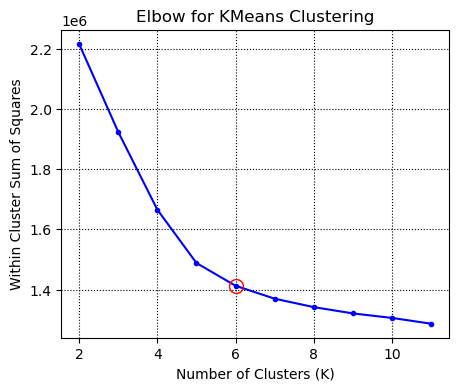

In [17]:

Ks = range(2, 12)
KMs = [KMeans(n_clusters=k, random_state=0, n_init=30).fit(X_train.values) for k in Ks]
centroids = [k.cluster_centers_ for k in KMs]

# compute euclidean distance between each point and each centroid
dists_by_ks = [cdist(X_train.values, mid, 'euclidean') for mid in centroids]
# get minimum distance per point, i.e., distance from assigned centroid
min_distances = [np.min(d, axis=1) for d in dists_by_ks] 
# total within sum of squares
tss = [sum(d**2) for d in min_distances]

# more succint way to get tss and elbo plot
# dists = {k.n_clusters:k.inertia_ for k in KMs}
# pd.DataFrame.from_dict(dists, orient='index').plot()

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(Ks, tss, '.-', color='blue')
ax.plot(Ks[4], tss[4], marker='o', markersize=10, markeredgewidth=1, markeredgecolor='r', markerfacecolor='None')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Within Cluster Sum of Squares')
ax.set_title('Elbow for KMeans Clustering')
plt.show()

In [18]:
n_clusters = 6

df_res = X_scaled_pca.copy()

km = KMeans(n_clusters=n_clusters, random_state=0, n_init=30)
df_res['km'] = km.fit_predict(X_train.values)

hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_res['hc'] = hc.fit_predict(X_train.values)


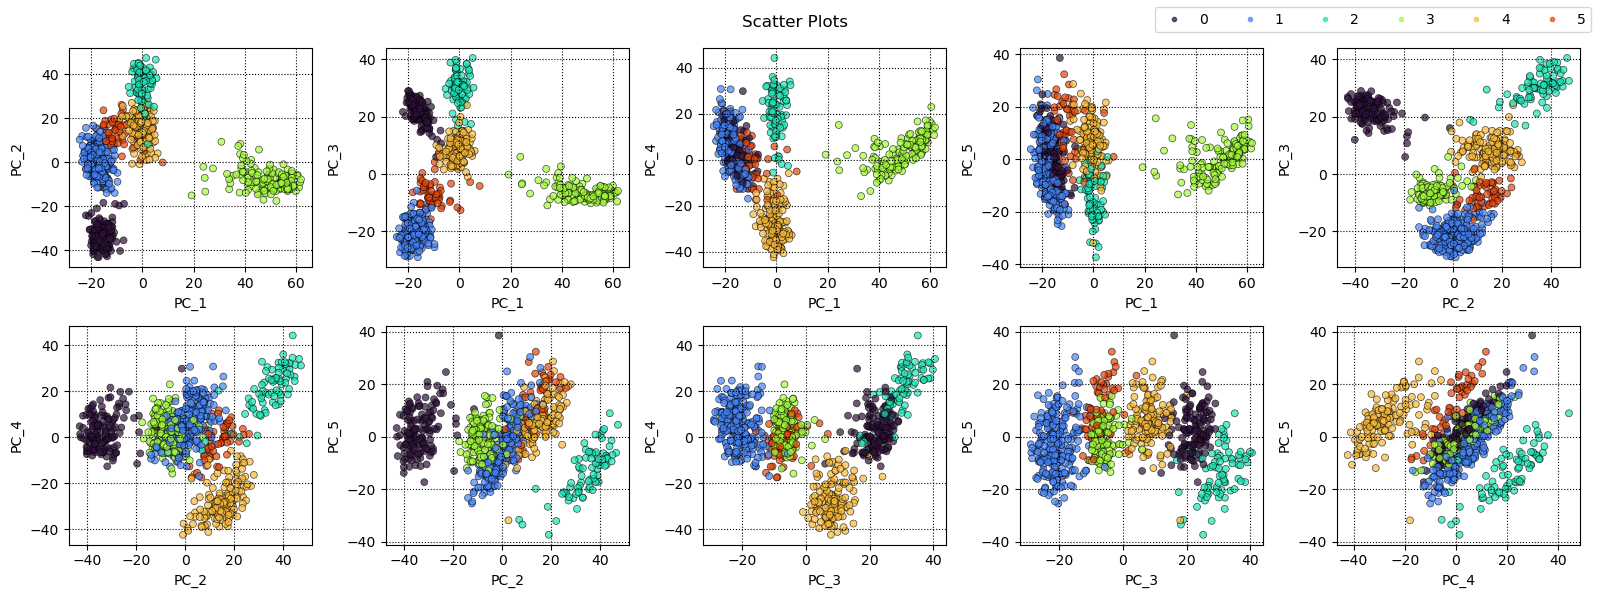

In [19]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=df_res, pairs=pairs, m=2, n=5, color_by=df_res['km'])

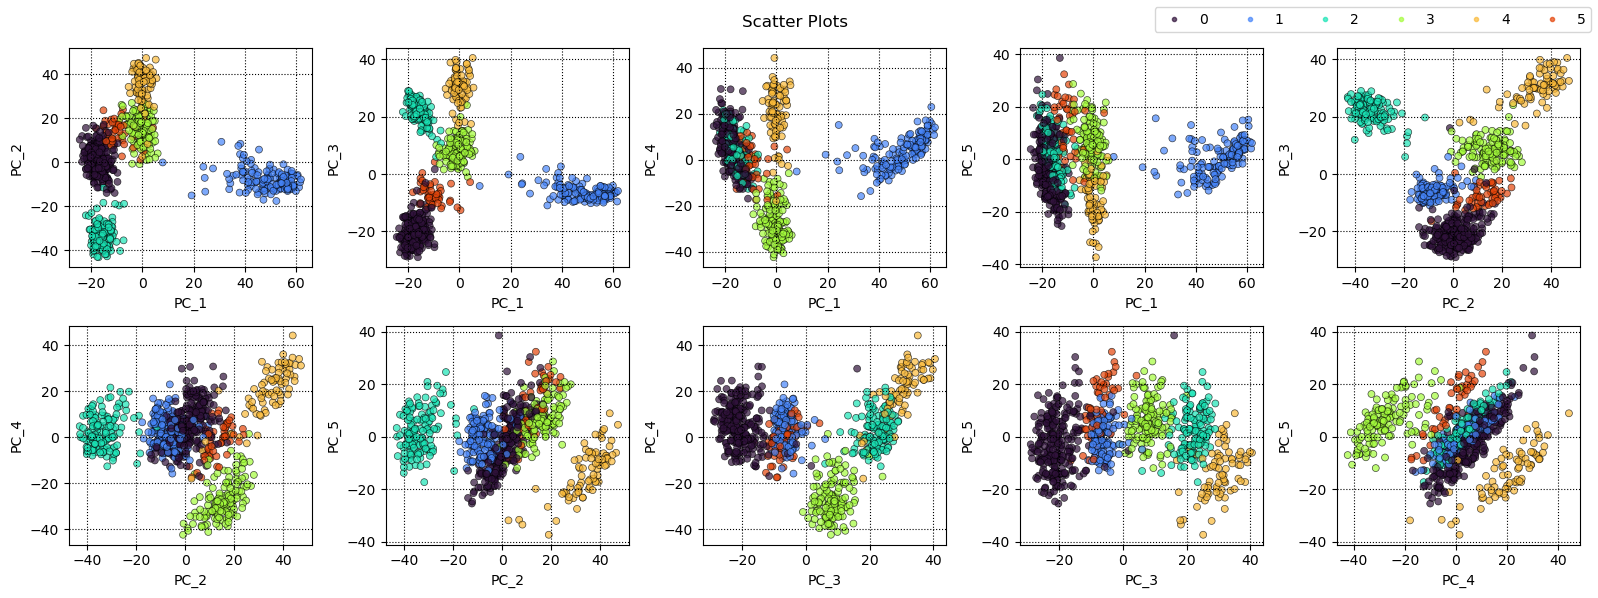

In [20]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=df_res, pairs=pairs, m=2, n=5, color_by=df_res['hc'])